In [1]:
from scipy.integrate import odeint
from scipy.interpolate import UnivariateSpline
from scipy.integrate import solve_ivp
from scipy.sparse import *
import time
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import json
from jupyterthemes import jtplot

from differential_equation import Solver
# MCEq Imports
from MCEq.particlemanager import ParticleManager
import MCEq.core    
from MCEq.core import MCEqRun
from MCEq.data import Decays
import mceq_config as config
#import primary model choices
import crflux.models as pm

config.A_target=1.27
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
config.muon_helicity_dependence=True

config.debug_level = 0

# Launcing mceq
mceq_run = MCEqRun(
    #provide the string of the interaction model
    interaction_model='SIBYLL23CPP',
    #primary cosmic ray flux model
    primary_model = (pm.HillasGaisser2012, "H3a"),
    
    # Zenith angle in degrees. 0=vertical, 90=horizontal
    theta_deg=0.0
    
)







In [2]:


jtplot.style(theme="grade3", context="notebook", ticks=True, grid=False)

In [3]:
list_particles=[mceq_run.pman[2212],     #p+           (0)
                mceq_run.pman[-2212],     #pbar-        (1)
                mceq_run.pman[2112],     #n            (2)
                mceq_run.pman[-2112],    #nbar         (3)
                mceq_run.pman[211],      #pi+          (4)
                mceq_run.pman[-211],     #pi-          (5)
                mceq_run.pman[310],      #K_S0         (6) 
                mceq_run.pman[130],      #K_L0         (7)
                mceq_run.pman[321],      #K+           (8)
                mceq_run.pman[-321],     #K-           (9)
                mceq_run.pman[111],      #pi0          (10)
                mceq_run.pman[-3122],    #Lambdbar0    (11)
                mceq_run.pman[3122],     #Lambda0      (12)
                mceq_run.pman[13],   #mu-          (13)
                mceq_run.pman[-13],  #mu+          (14)
                mceq_run.pman[-11],      #e+           (15)   
                mceq_run.pman[11],       #e-           (16)
                mceq_run.pman[12],       #numu         (23)
                mceq_run.pman[-12],      #numubar      (24)
                mceq_run.pman[14],       #nue          (21)
                mceq_run.pman[-14],      #nuebar       (22)
                mceq_run.pman[22]#gamma        (25)
               ]


"""""
For indices of the particles in phi 
"""""
j=0
ind={}
for i in list_particles:
    ind[i.name,'up']=0+j
    ind[i.name,'low']=121+j
    j=j+121



#list of pdg ids 
list_particles_pdg_id=[]
for i in range(0,len(list_particles)):
    list_particles_pdg_id.append(list_particles[i].pdg_id[0])
    


Name=[r"$P^{+}$",
      r"$\overline{P}^{-}$",
      r"$n^0$",
      r"$\overline{n}$",
      r"$\pi^{+}$",
      r"$\pi^{-}$",
      r"$K_{S}^0$"
      ,r"$K_{L}^0$",
      r"$K^{+}$",
      r"$K^{-}$",
      r"$\pi^{0}$",
      r"$\overline{\Lambda}^{0}$",
      r'$\Lambda^{0}$',
      r"$\mu^{-}$",
      r"$\mu^{+}$",
      r"$e^{+}$",
      r"$e^{-}$",
      r"$\nu_{e}$",
      r"$\overline{\nu}_{e}$",
      r"$\nu_{\mu}$"
      ,r"$\overline{\nu}_{\mu}$" ,
      r'$\gamma$'
    
]




In [4]:
len(Name),len(list_particles)

(22, 22)

In [5]:


"""""
The primary fluxes
"""""
phi=np.zeros(len(list_particles)*121)
phi0_p = (
    mceq_run._phi0[mceq_run.pman[2212].lidx:mceq_run.pman[2212].uidx]
)
phi0_n=(
    mceq_run._phi0[mceq_run.pman[2112].lidx:mceq_run.pman[2112].uidx]
)
phi[242:363]=phi0_n
phi[0:121]=phi0_p




In [6]:
import codecs
file = codecs.open('/home/kruteesh/Desktop/Solar_neutrinos/diffsec/rho.txt', 'r', 'UTF-8')
print(file)
tline = file.readlines()
b=tline[5:]
r_ratio=[]
rho_data=[]
c=[]
for i in b:
    r_ratio.append(float(i.split(' ')[1]))

    rho_data.append(float(i.split(' ')[3]))

In [7]:


"The Sun and the X for the path from sun "
R_sun=6.957e10
h_list=[0,0.01,0.1,0.2,0.4,0.5,0.8, 0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97
        ,0.98,0.99,0.995,0.999,0.9995,0.9999,0.99999,0.999995,0.9999995,
       0.9999996,0.9999997,0.9999998,0.9999999,0.99999991,0.99999992,0.99999993,0.99999994
        ,0.99999995,0.99999996,0.99999997,0.99999998,0.99999999]
new_h=np.array([h*R_sun for h in h_list])
print(new_h)

X=Solver(list_particles,R_sun,new_h,phi).X_rho(r_ratio[70:],rho_data[70:])
"""""
x2rho={}
final_X={}#the dictionaries
for h in new_h:
    rhh=rho(R_sun,h,r_ratio,rho_data)
    x2rho[h]=rhh.X2rho()
    final_X[h]=rhh.final_X()
  
    
# In[34]:
"""""

[0.00000000e+00 6.95700000e+08 6.95700000e+09 1.39140000e+10
 2.78280000e+10 3.47850000e+10 5.56560000e+10 6.26130000e+10
 6.33087000e+10 6.40044000e+10 6.47001000e+10 6.53958000e+10
 6.60915000e+10 6.67872000e+10 6.74829000e+10 6.81786000e+10
 6.88743000e+10 6.92221500e+10 6.95004300e+10 6.95352150e+10
 6.95630430e+10 6.95693043e+10 6.95696522e+10 6.95699652e+10
 6.95699722e+10 6.95699791e+10 6.95699861e+10 6.95699930e+10
 6.95699937e+10 6.95699944e+10 6.95699951e+10 6.95699958e+10
 6.95699965e+10 6.95699972e+10 6.95699979e+10 6.95699986e+10
 6.95699993e+10]
0.0
695700000.0
6957000000.0
13914000000.0
27828000000.0
34785000000.0
55656000000.0
62613000000.0
63308700000.0
64004400000.0
64700100000.0
65395800000.0
66091500000.0
66787200000.0
67482900000.0
68178600000.0
68874300000.0
69222150000.0
69500430000.0
69535215000.0
69563043000.0
69569304300.0
69569652150.0
69569965215.0
69569972172.0
69569979129.0
69569986086.0
69569993043.0
69569993738.7
69569994434.40001
69569995130.1
695699958

'""\nx2rho={}\nfinal_X={}#the dictionaries\nfor h in new_h:\n    rhh=rho(R_sun,h,r_ratio,rho_data)\n    x2rho[h]=rhh.X2rho()\n    final_X[h]=rhh.final_X()\n  \n    \n# In[34]:\n'

In [8]:

#dphidE4=pickle.load(open("11,01,21.pkl","rb"))
#r_ivp=pickle.load(open("22,01,21_ivp.pkl","rb"))
dphidE=pickle.load(open("/home/kruteesh/Desktop/Solar_neutrinos/data/20,01,21.pkl","rb"))
dphidE_2=pickle.load(open("/home/kruteesh/Desktop/Solar_neutrinos/data/05,02,21.pkl","rb"))

#dphidE_3=pickle.load(open("/home/kruteesh/Desktop/Solar_neutrinos/data/05,02,21.pkl","rb"))
dphidE_i_ms=pickle.load(open("/home/kruteesh/Desktop/Solar_neutrinos/data/29,01,21_i_ms.pkl","rb"))
#dphidE3=pickle.load(open("13,01,21.pkl","rb"))

In [9]:
dphidE_2.keys()

dict_keys([69569965215.0, 69569972172.0, 69569979129.0, 69569986086.0, 69569993043.0, 69569993738.7, 69569994434.40001, 69569995130.1, 69569995825.8, 69569996521.5, 69569997217.2, 69569997912.9, 69569998608.6, 69569999304.3])

In [10]:
#dphidE.update(dphidE2)
dphidE.update(dphidE_2)
""""dphidE.update(dphidE3)"""""
I_models=['EPOSLHC', 'DPMJETIII306', 'QGSJETII04', 'SIBYLL23C03']



In [11]:
dphidE.keys()

dict_keys([0.0, 695700000.0, 6957000000.0, 13914000000.0, 27828000000.0, 34785000000.0, 55656000000.0, 62613000000.0, 63308700000.0, 64004400000.0, 64700100000.0, 65395800000.0, 66091500000.0, 66787200000.0, 67482900000.0, 68178600000.0, 68874300000.0, 69222150000.0, 69500430000.0, 69535215000.0, 69563043000.0, 69569304300.0, 69569652150.0, 69569999304.3, 69569965215.0, 69569972172.0, 69569979129.0, 69569986086.0, 69569993043.0, 69569993738.7, 69569994434.40001, 69569995130.1, 69569995825.8, 69569996521.5, 69569997217.2, 69569997912.9, 69569998608.6])

In [12]:
np.array([0.0, 695700000.0, 6957000000.0, 13914000000.0, 27828000000.0, 34785000000.0, 55656000000.0, 62613000000.0, 63308700000.0, 64004400000.0, 64700100000.0, 65395800000.0, 66091500000.0, 66787200000.0, 67482900000.0, 68178600000.0, 68874300000.0, 69222150000.0, 69500430000.0, 69535215000.0, 69563043000.0, 69569304300.0, 69569652150.0, 69569999304.3, 69569965215.0, 69569972172.0, 69569979129.0, 69569986086.0, 69569993043.0, 69569993738.7, 69569994434.40001, 69569995130.1, 69569995825.8, 69569996521.5, 69569997217.2, 69569997912.9, 69569998608.6])/R_sun

array([0.        , 0.01      , 0.1       , 0.2       , 0.4       ,
       0.5       , 0.8       , 0.9       , 0.91      , 0.92      ,
       0.93      , 0.94      , 0.95      , 0.96      , 0.97      ,
       0.98      , 0.99      , 0.995     , 0.999     , 0.9995    ,
       0.9999    , 0.99999   , 0.999995  , 0.99999999, 0.9999995 ,
       0.9999996 , 0.9999997 , 0.9999998 , 0.9999999 , 0.99999991,
       0.99999992, 0.99999993, 0.99999994, 0.99999995, 0.99999996,
       0.99999997, 0.99999998])

In [13]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


In [14]:

#X2r=Solver(list_particles,R_sun,new_h[:1],phi).X2R(np.array(r_ratio),np.array(rho_data))

In [15]:
import rho_X

In [16]:
x2r={}
x2l={}
rho={}
for h in new_h:
    x2r[h]=rho_X.rho(R_sun,h,r_ratio[70:],rho_data[70:]).X2R()
    x2l[h]=rho_X.rho(R_sun,h,r_ratio[70:],rho_data[70:]).X2l()
    rho[h]=rho_X.rho(R_sun,h,r_ratio[70:],rho_data[70:]).final_rho()

FileNotFoundError: [Errno 2] No such file or directory: '/home/kruteesh/Desktop/Solar_neutrinos/diffsec/pics/r2x/r2x0.0.png'

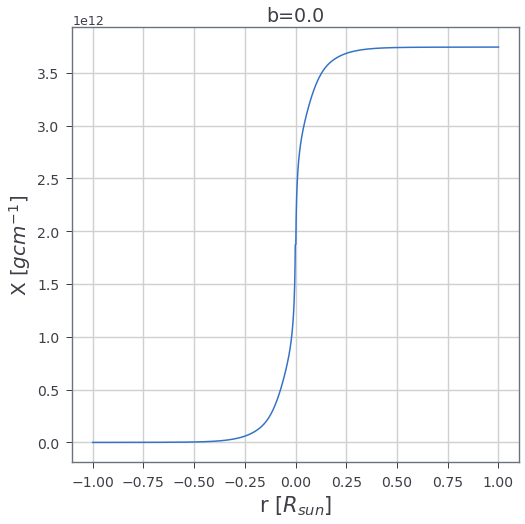

In [17]:

for h in [new_h[0],new_h[4],new_h[7],new_h[22]]:
    plt.figure(figsize=(8,8))
    plt.title('b='+str(h/R_sun),fontsize=19)
    plt.plot(x2r[h],X[h])
    plt.xlabel(r'r $[R_{sun}]$',fontsize=21)
    plt.ylabel(r'X $[g cm^{-1}]$',fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    plt.savefig('/home/kruteesh/Desktop/Solar_neutrinos/diffsec/pics/r2x/r2x'+str(h/R_sun)+'.png')
    

for h in [new_h[0],new_h[4],new_h[7],new_h[22]]:
    plt.figure(figsize=(8,8))
    plt.title('b='+str(h/R_sun),fontsize=19)
    plt.plot(x2r[h],rho[h])
    plt.xlabel(r'r $[R_{sun}]$',fontsize=21)
    plt.ylabel(r'X $[g cm^{-1}]$',fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    plt.savefig('/home/kruteesh/Desktop/Solar_neutrinos/diffsec/pics/r2rho/r2rho'+str(h/R_sun)+'.png')



In [21]:
name_lepton=[Name[19],Name[17],r"$\overline{\nu}_{e}$",r"$\overline{\nu}_{\mu}$"]
print(name_lepton)

['$\\nu_{\\mu}$', '$\\nu_{e}$', '$\\overline{\\nu}_{e}$', '$\\overline{\\nu}_{\\mu}$']


In [96]:
e_ind=[41,51,61,71]
E_grid=np.array([mceq_run.e_grid[i] for i in e_ind])


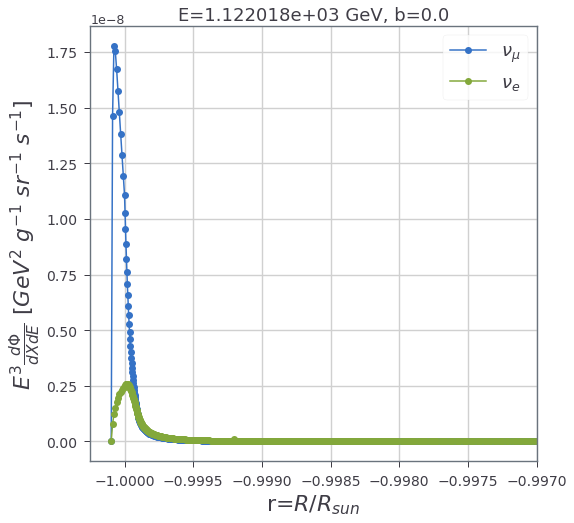

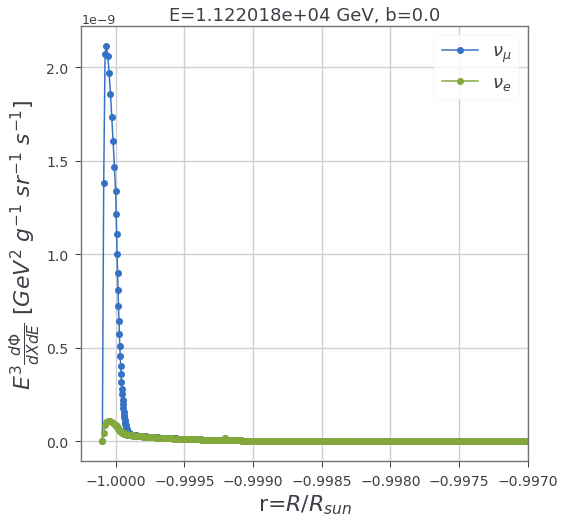

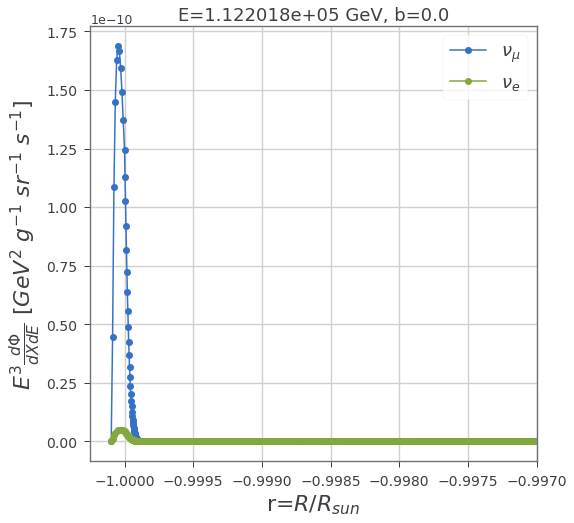

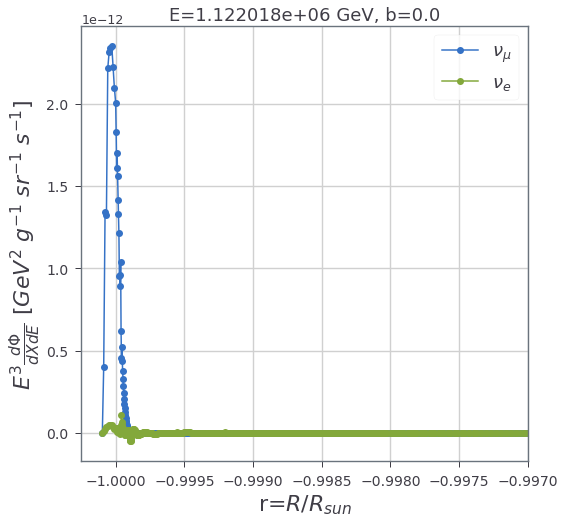

In [18]:

h=0
for e,E in enumerate(E_grid):
    plt.figure(figsize=(8,8))
    plt.title('E='+'{:e}'.format(E)+' GeV, b='+str(h/R_sun),fontsize=18)
    for n,p in enumerate([mceq_run.pman[14],mceq_run.pman[12]]):
        bb_1=np.array([])
        bb_2=dphidE[h].T[ind[p.name,'up']:ind[p.name,'low']][e_ind]
        for i,j in enumerate(dphidE[h]):             
            bb_1=np.append(
                    bb_1,
                    ((dphidE[h].T[ind[p.name,'up']:ind[p.name,'low']][e_ind[e]][i]
                      -dphidE[h].T[ind[p.name,'up']:ind[p.name,'low']][e_ind[e]][i-1])*E**3/
                     (((X[h][i]-X[h][i-1]))))
)
        
        #print(max(bb_1))         
        plt.plot(x2r[h],(bb_1),'-o',label=name_lepton[n])
        #plt.plot(t_tmp[h,'x2r'],rho[h])
    plt.xlim((-1.00025,-0.997))
    #plt.xlim((0,200))
    plt.xlabel(r"r=$R/R_{sun} $",fontsize=22)
    plt.ylabel(r'$E^3\frac{d\Phi}{dXdE}$ $[GeV^{2}$ $g^{-1}$ $sr^{-1}$ $s^{-1}]$',fontsize=22)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    plt.savefig("/home/kruteesh/Desktop/Solar_neutrinos/diffsec/analysis_testing/production/production_"+str(E)+".png")


In [82]:
E=mceq_run.e_grid[40]
p=mceq_run.pman[-14]#
j=np.array([])

In [83]:
for h in h_list:
    j=np.append(j,dphidE[h*R_sun][-1][ind[p.name,'up']:ind[p.name,'low']][40])

In [84]:
np.sum(j)

5.783772011128828e-14

In [77]:
2.3001516799785046e-14+2.3138589990628668e-14

4.614010679041371e-14

In [85]:
5.6834075096937614e-14+5.783772011128828e-14

1.146717952082259e-13

In [62]:
#differential flux for numu,antinumu at E_grid[41]
5.823501296564013e-14+2.4688186217681745e-14

8.292319918332187e-14

In [39]:
#the sum of numu, nue, antinumu, antinue over entire solar disk at E_grid[40]
5.672594260583468e-14+5.822525768541996e-14

1.1495120029125463e-13

In [ ]:
+2.6977335631169067e-14+1.8525088113540957e-14

In [23]:
1.0714389407399e-14+7.358581939078477e-15+2.3248674635002794e-14+2.2951526694983137e-14

6.427317267646341e-14

In [57]:
xx=np.array([1.1495e-13,8.29232e-14])
yy=np.array([0.89,1.122])

In [91]:
UnivariateSpline(yy,xx,k=1,s=1,ext=0)(1)

array(9.97648793e-14)

In [24]:
mceq_run.e_grid[40],mceq_run.e_grid[70]

(891.2509381337459, 891250.9381337459)

In [25]:
ls=['r-.','g-.','b-.','y-.']
ls_2=['ro','go','bo','yo']

<ipython-input-26-315350351bf9>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,8))


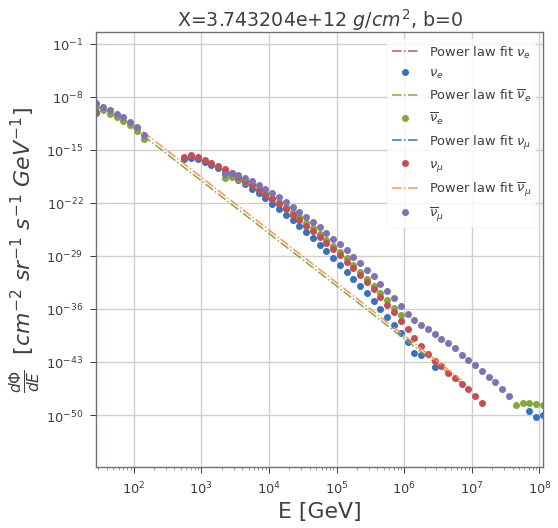

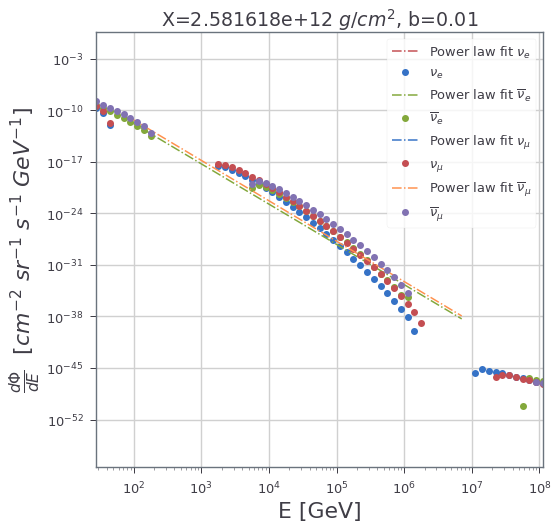

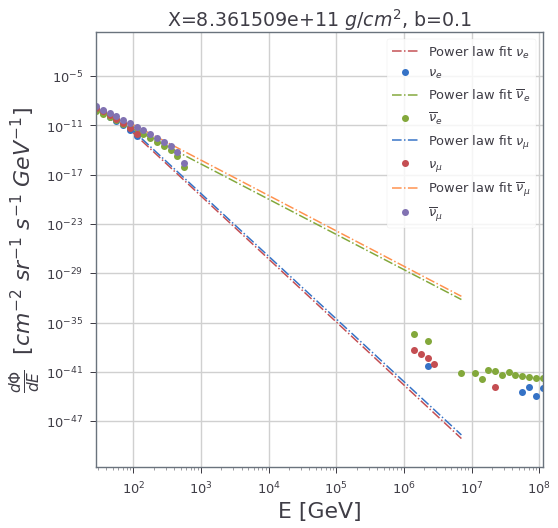

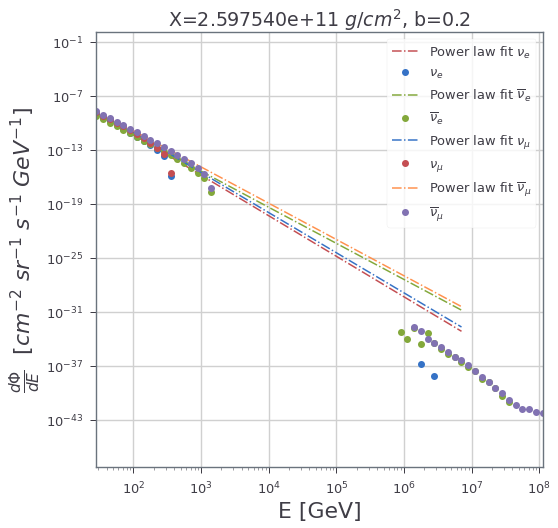

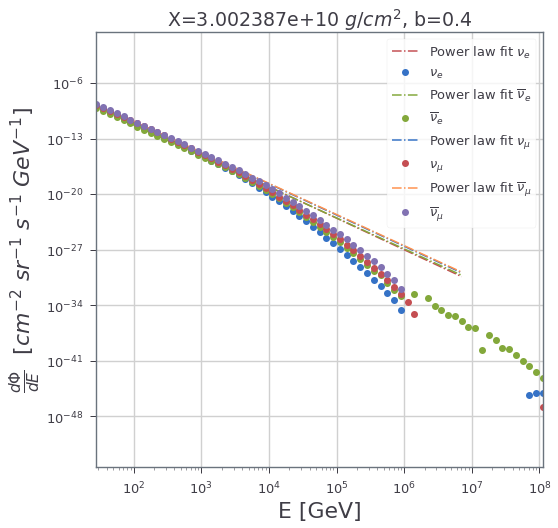

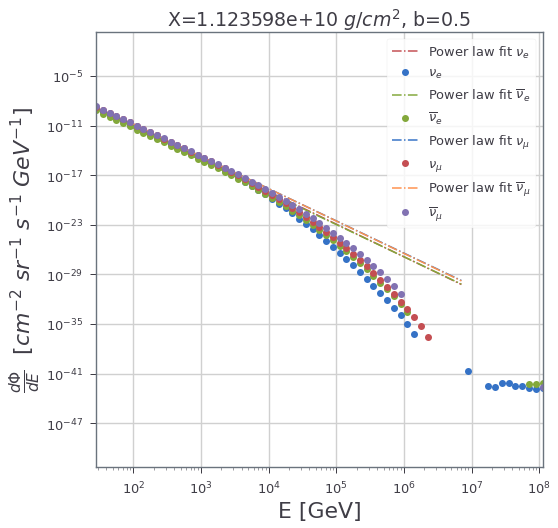

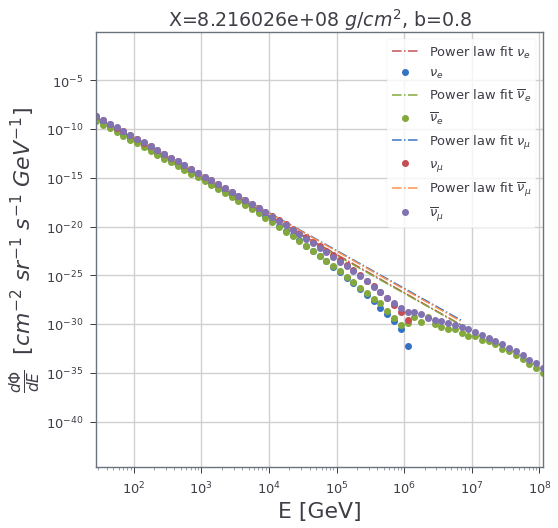

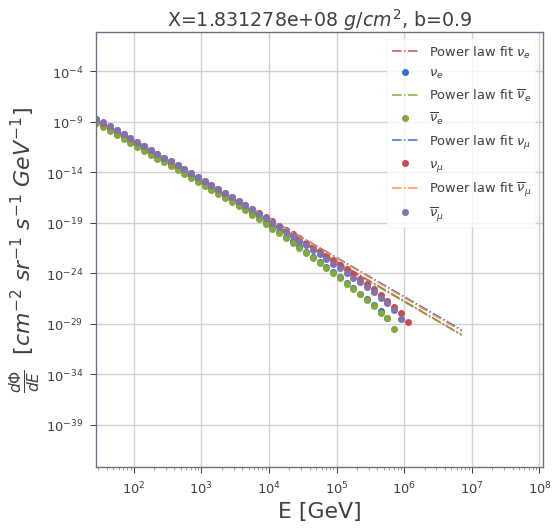

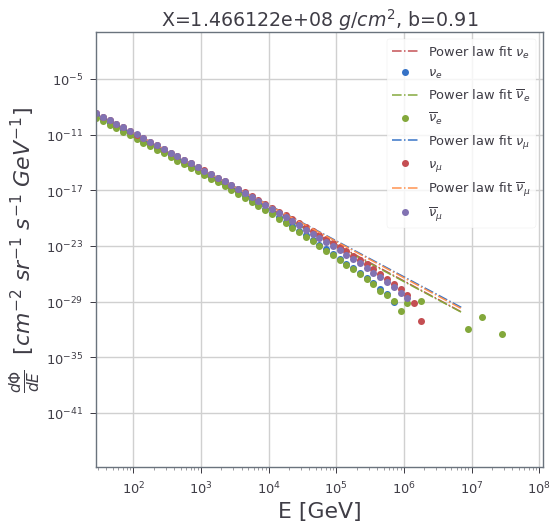

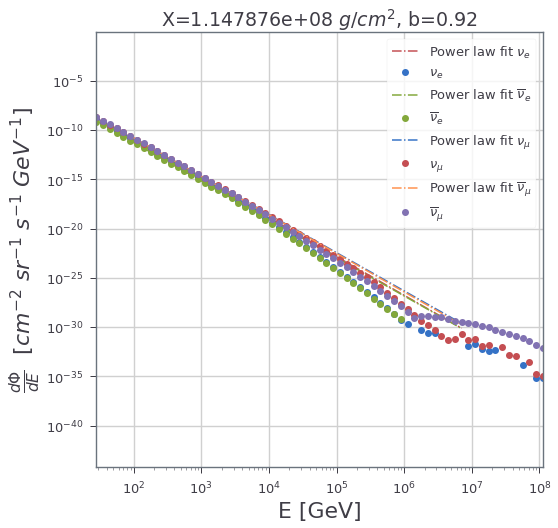

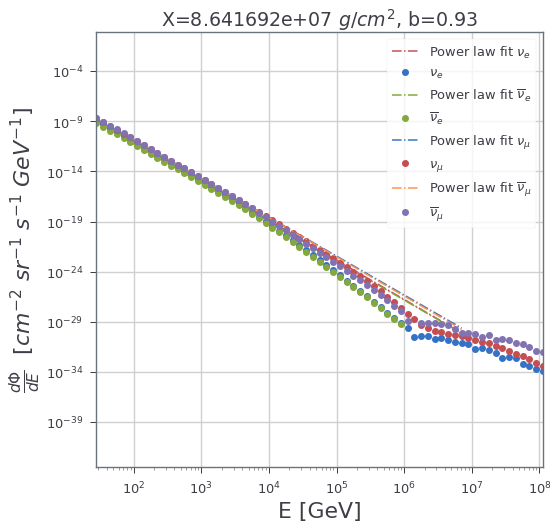

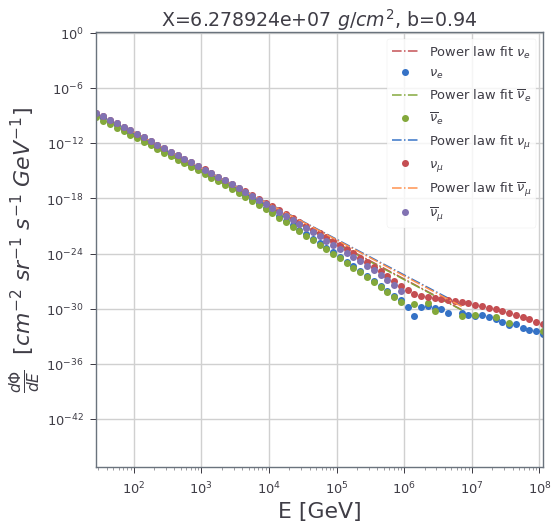

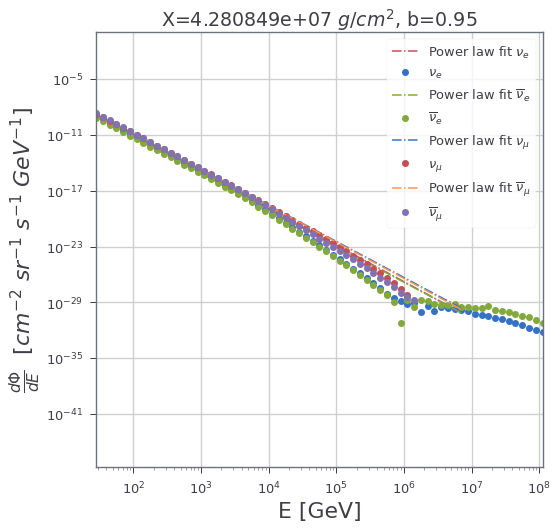

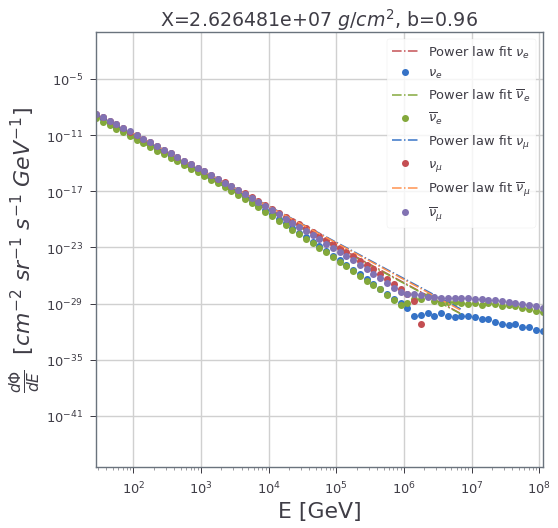

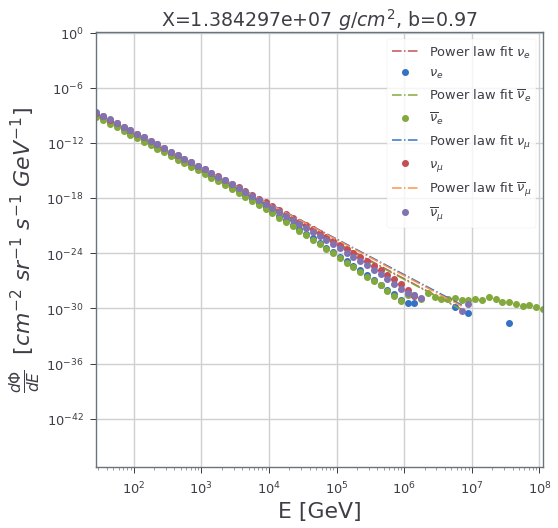

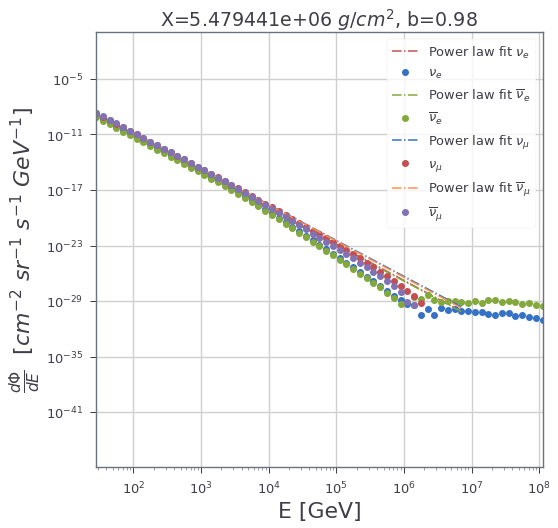

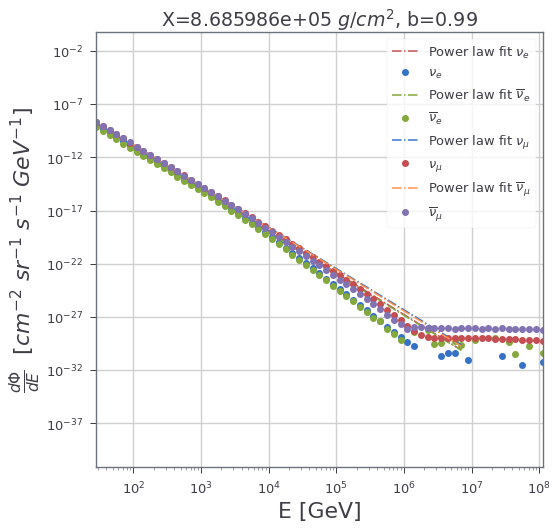

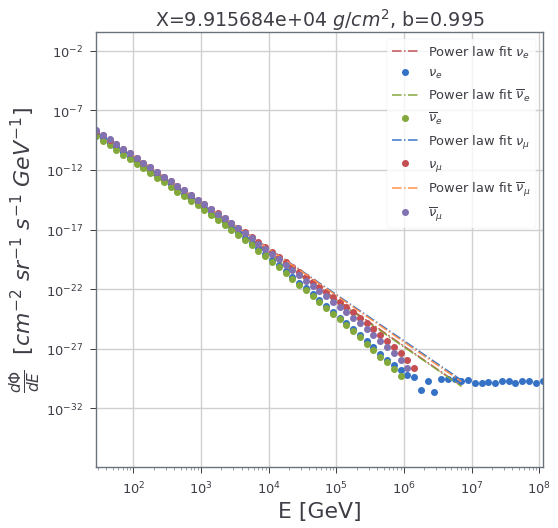

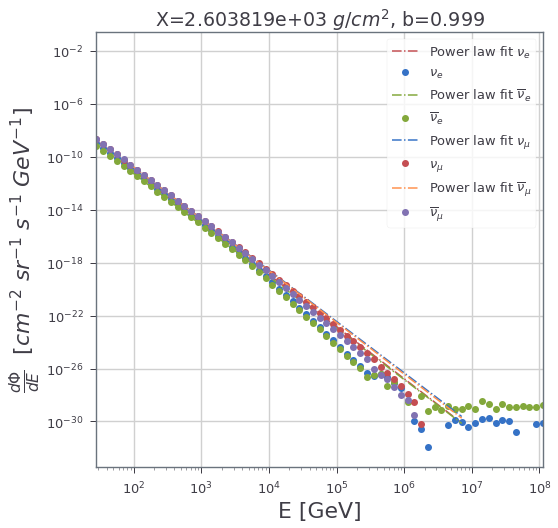

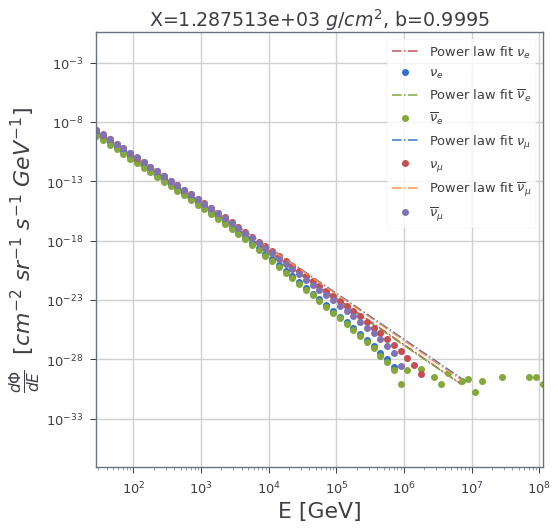

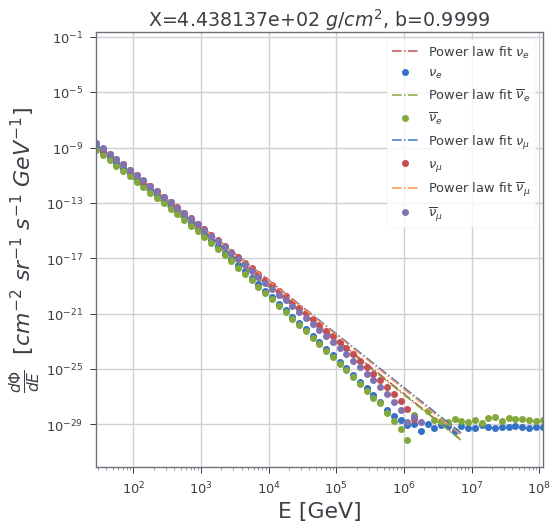

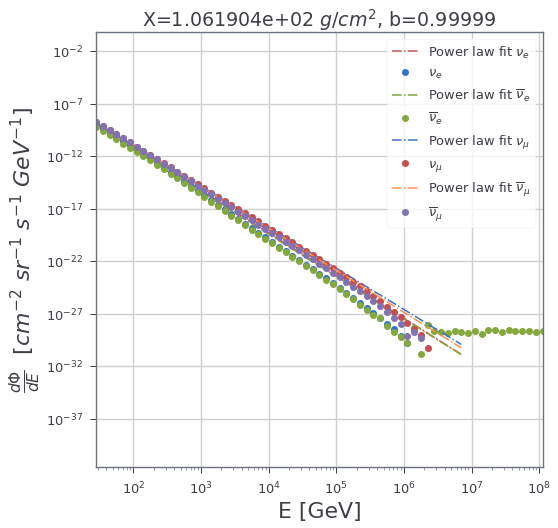

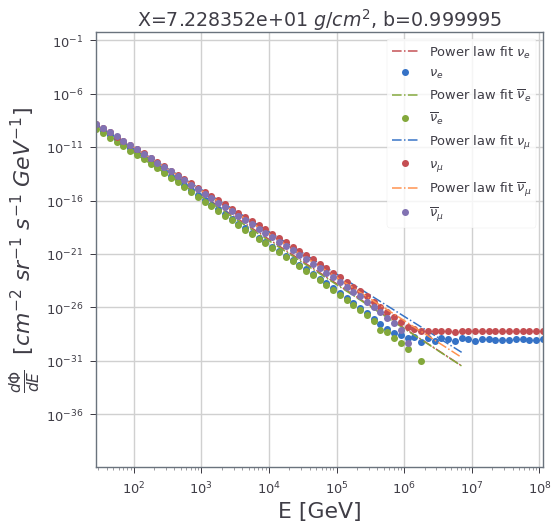

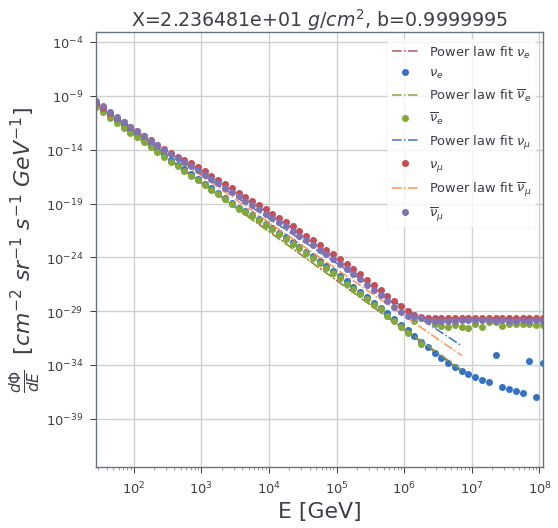

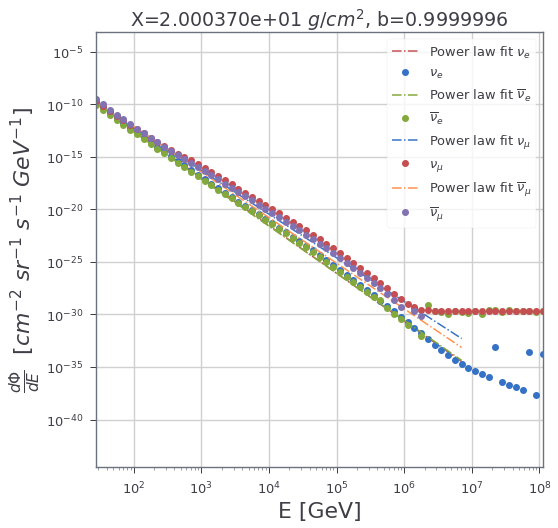

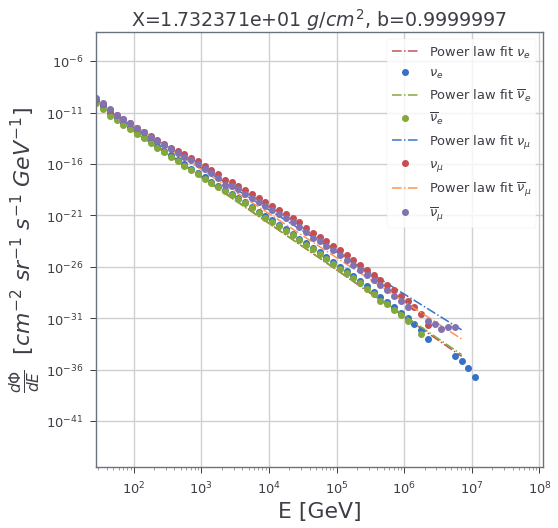

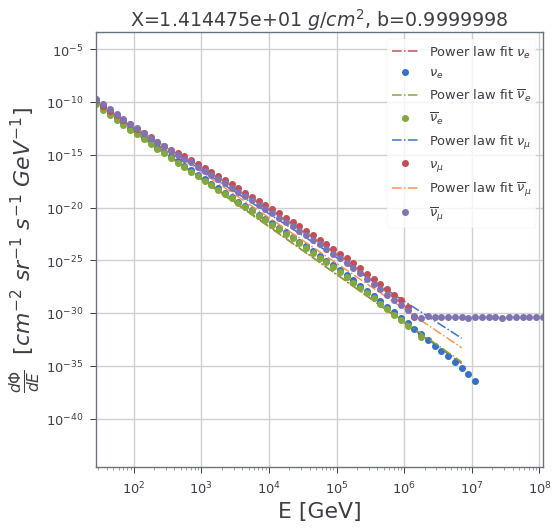

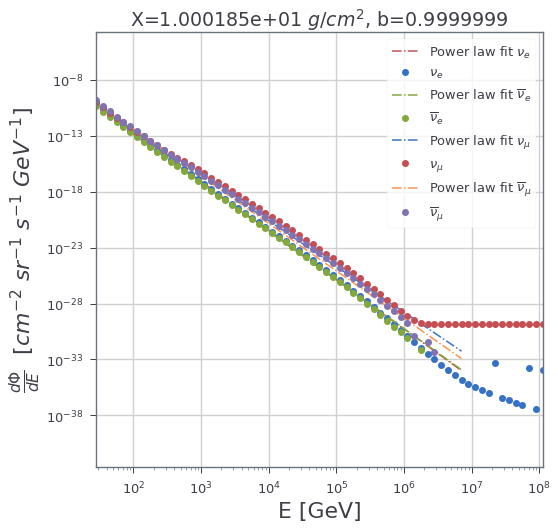

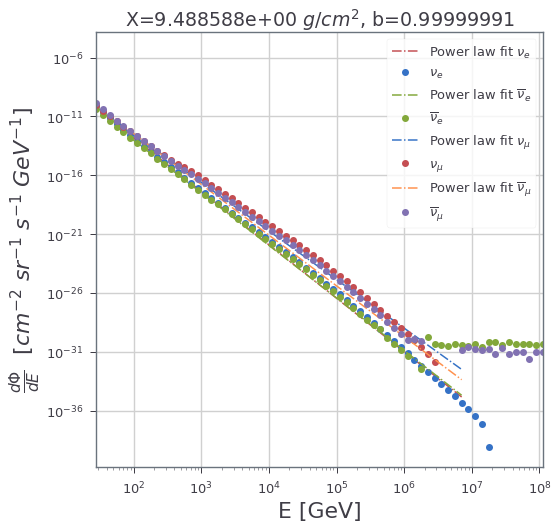

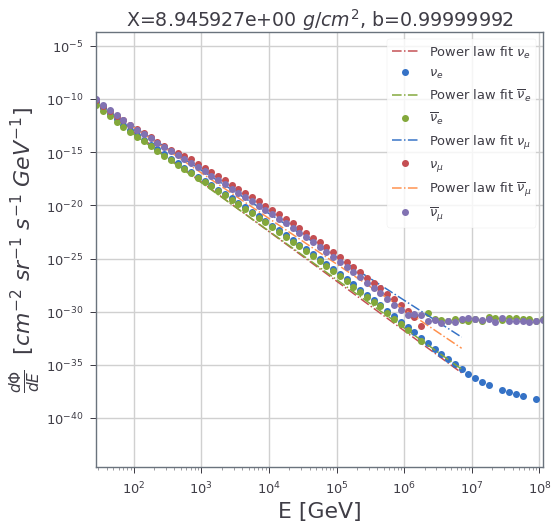

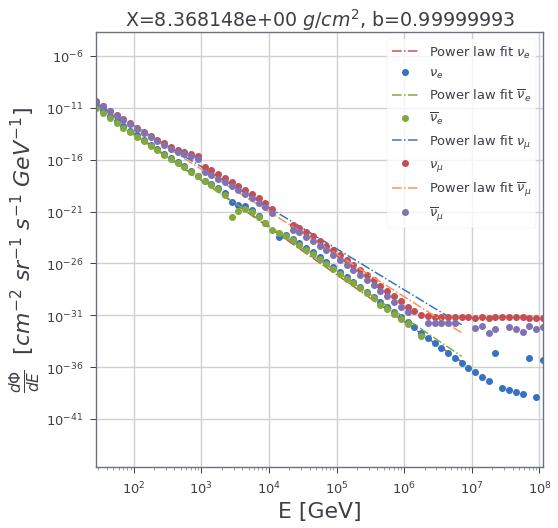

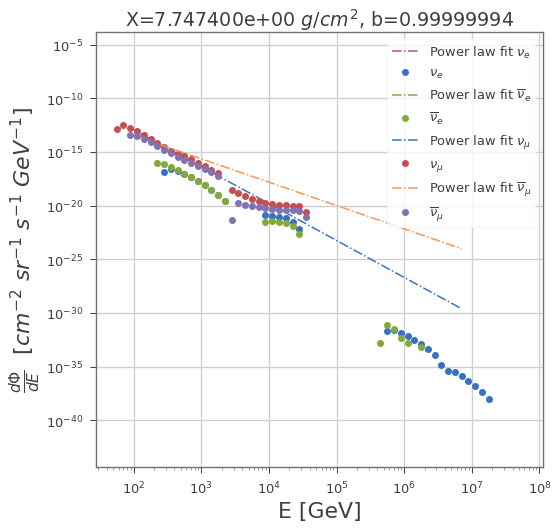

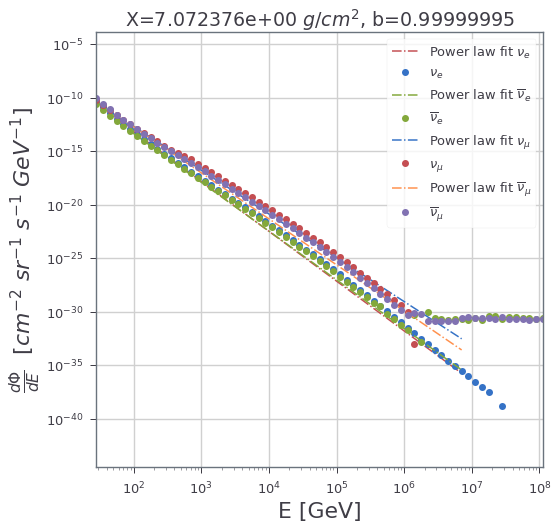

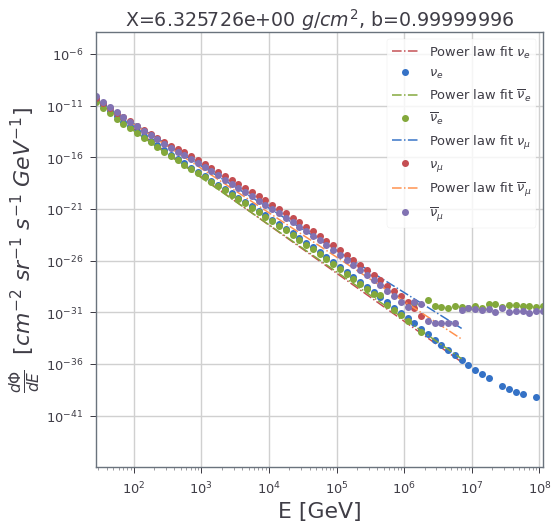

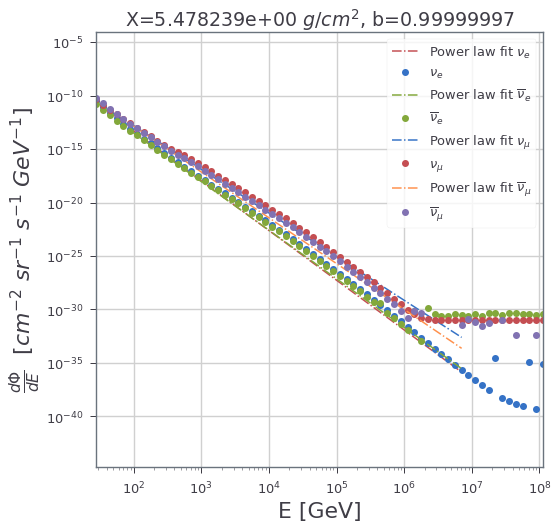

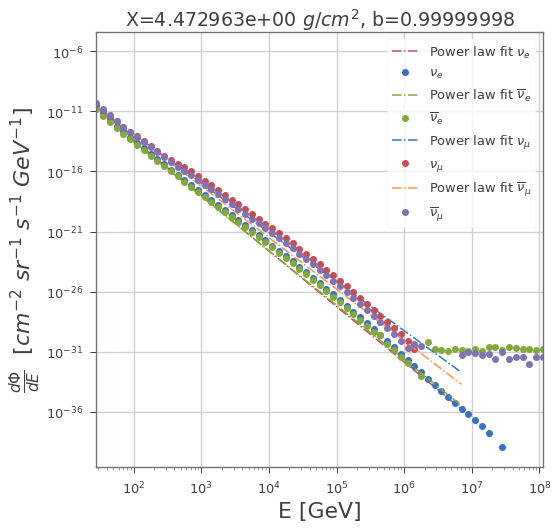

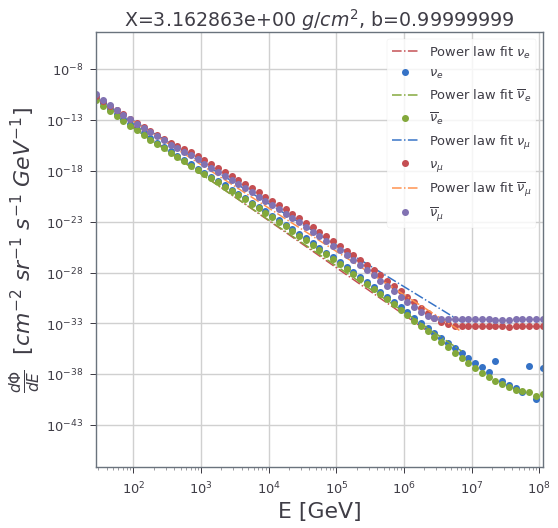

In [26]:
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
up=30
down=80
def f(x,a,b):
    return a*x**(-b)
gamma={}
for i,h in enumerate(h_list):
    plt.figure(figsize=(8,8))
    plt.title('X='+'{:e}'.format(X[new_h[i]][-1])+r" $ g/cm^2$"+", b="+str(h),fontsize=19)

    for j,p in enumerate(list_particles[17:-1]):
        bb_1=(dphidE[h_list[i]*R_sun])

                #bb_2=np.transpose(sol_ivp_csr[h_list[i+1]*R_sun]['y'])
                #phi_ratio=bb_1[-1][ind[p.name,'up']:ind[p.name,'low']]/ bb_2[-1][ind[p.name,'up']:ind[p.name,'low']]
        rr=(bb_1[-1][ind[p.name,'up']:ind[p.name,'low']])

        popt,pcov=curve_fit(f,mceq_run.e_grid[up:down],rr[up:down])
        gamma[h,p.name,"b","1st_half"]=popt[1]
        gamma[h,p.name,"a","1st_half"]=popt[0]
        #print(popt)#rr=rr*(mceq_run.e_grid**3)
        plt.plot(mceq_run.e_grid[up:down],(f(mceq_run.e_grid,popt[0],popt[1])[up:down]),ls[j],label="Power law fit "+Name[j+17])
        
        plt.plot(mceq_run.e_grid,rr ,'o',label=Name[j+17])
        
    #plt.plot(mceq_run.e_grid,phi0_p  ,"r",label='p initail')
    plt.grid()
    plt.xlim((mceq_run.e_grid[up-5],mceq_run.e_grid[down+11]))
    #plt.ylim((1e-10,1e5))
    plt.xlabel('E [GeV]',fontsize=22)
    plt.ylabel(r'$\frac{d\Phi}{dE}$  $[cm^{-2}$ $sr^{-1}$ $s^{-1}$ $GeV^{-1}]$',fontsize=22)
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(fontsize=13)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
   # plt.savefig("/home/kruteesh/Desktop/Solar_neutrinos/diffsec/analysis_testing/dphide/dphi_"+str(h)+".png")

In [27]:

b_g={}


In [28]:
gamma[0.1,'nue','b','1st_half']

7.664585227403787

In [29]:
#1st half is between mceq_run.e_grid[20,60]
for particle in list_particles[17:-1]:
    b=[]
    for h in h_list:
        b.append(gamma[h,particle.name,"b","1st_half"])
    b_g[particle.name,"1st_half"]=b

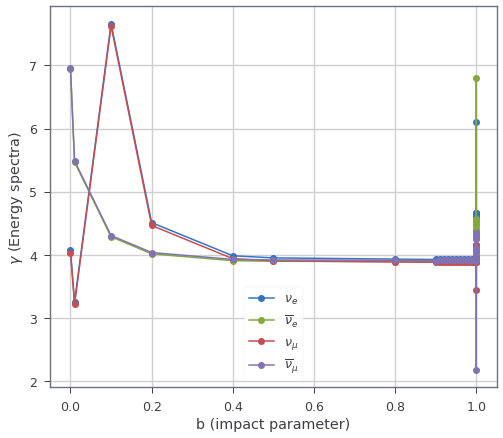

In [30]:
for j,particle in enumerate(list_particles[17:-1]):
    plt.plot(h_list,b_g[particle.name,"1st_half"],"o-",label=Name[j+17])

plt.ylabel(r"$\gamma$ (Energy spectra) ")
plt.xlabel(r"b (impact parameter)")
#plt.xlim((0.9999995,1.0000001))
plt.legend()
plt.grid()

In [31]:
b_a={}
#1st half is between mceq_run.e_grid[20,60]
for particle in list_particles[17:-1]:
    b=[]
    for h in h_list:
        b.append(gamma[h,particle.name,"a","1st_half"])
    b_a[particle.name,"1st_half"]=b

[-0.0002249321184912171, -6.5895631291118684e-06, 2434.5783835178977, 0.00544030504610368, 0.0007598257616159981, 0.0006726013524872286, 0.0006279583280337242, 0.0006108968976259823, 0.0006253273877020071, 0.000625009294122574, 0.0006251725931630094, 0.0006251503799214511, 0.0006251288869017236, 0.0006251510926340721, 0.0006251885749099497, 0.000625357209576733, 0.0006255862942919604, 0.0006251196801563013, 0.0006255897505423855, 0.0006256345973661102, 0.000632914649327337, 0.0008703045384774624, 0.0010300569388025298, 0.0004917229150129389, 0.00046692379315782653, 0.0002757548943499509, 0.0003061938089291176, 0.00012775547679825044, 0.0001755138405230526, 0.00016377848762970208, 4.603927855594399e-05, -0.04077518102880677, 0.00013477526678612657, 0.00011388193021790316, 9.582600981520418e-05, 7.498903948824867e-05, 4.3580983325564644e-05]
[56.44334500632949, 0.13241116379143228, 0.0013459370141770985, 0.00049748876217566, 0.0003329358318826167, 0.0003223226562053022, 0.000316666957632

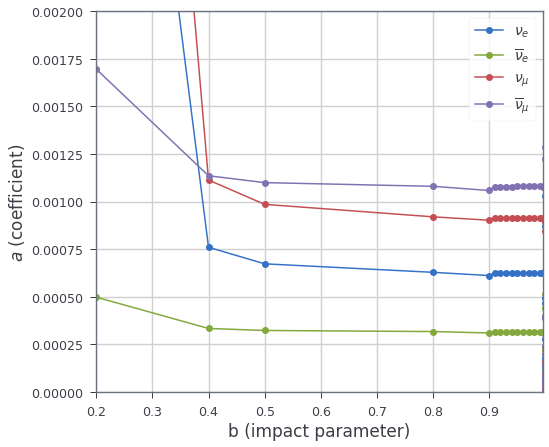

In [80]:
for j,particle in enumerate(list_particles[17:-1]):
    plt.plot(h_list,b_a[particle.name,"1st_half"],"o-",label=Name[j+17])
    print(b_a[particle.name,'1st_half'])
plt.ylabel(r"$a$ (coefficient) ",fontsize=17)
plt.xlabel(r"b (impact parameter)",fontsize=17)
plt.xlim((0.2,0.995))
plt.ylim((0,2e-3))
plt.legend(fontsize=14)
plt.grid()

In [94]:
name_lepton


['$\\nu_{\\mu}$', '$\\nu_{e}$']

In [3]:
mceq_run.e_grid[80],8912509.38133745

8912509.381337458

In [19]:
up=30
import matplotlib.pyplot as plt
import numpy as np
phi_t={}

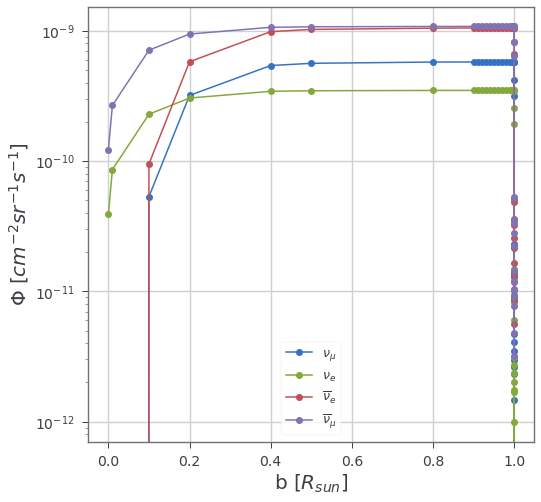

In [22]:
plt.figure(figsize=(8,8))
for i,p in enumerate([mceq_run.pman[12],mceq_run.pman[-12],mceq_run.pman[14],mceq_run.pman[-14]]):
    phi_t[p.name]=np.array([])
    #print(p.name)
    for h in new_h:

        bb_1=(dphidE[h])
        rr=(bb_1[-1][ind[p.name,'up']:ind[p.name,'low']])
        
        phi_t[p.name]=np.append(phi_t[p.name],np.sum(rr[up:]*mceq_run.e_widths[up:]))

        #print(np.sum(rr[up:]*mceq_run.e_widths[up:]),h/R_sun)
    hh=h_list[::-1]
    plt.plot(h_list,phi_t[p.name],'o-',label=name_lepton[i])
#plt.xlim(0.9999995, 1.00000002)  # decreasing time
#plt.ylim((1e-13,1e-10))
plt.yscale("log")
plt.xlabel(r"b $[R_{sun}]$",fontsize=20)
plt.ylabel(r"$\Phi$ $[cm^{-2}sr^{-1}s^{-1}]$",fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend()
    

In [36]:
phi_t.keys()

dict_keys(['nue', 'antinue', 'numu', 'antinumu'])

In [37]:
#total phi ---------
def theta(b,r_e,r):
    return np.arcsin(b*r/r_e)
phi_t_disk={}
R_e=1.3e13

def gamma(b,R_sun,R_e):
    return -(np.arcsin(b*R_sun/R_e))+np.arcsin(b)

def r_disk(b,R_sun,R_e):
    return np.sin(gamma(b,R_sun,R_e))*R_sun


In [38]:
phi_t_disk.keys()

dict_keys([])

In [39]:
for p in  [mceq_run.pman[12],mceq_run.pman[14],mceq_run.pman[-14],mceq_run.pman[-12]]:
    phi_t_disk[p.name]=np.array([])
    for i,phi in enumerate(phi_t[p.name]):
        
        if i==0:
            phi_t_disk[p.name]=np.append(phi_t_disk[p.name],phi*(r_disk(h_list[i],R_sun,R_e))*
                                2*np.pi*
                                ((r_disk(h_list[i+1],R_sun,R_e)-r_disk(h_list[i],R_sun,R_e))))
        elif i==len(phi_t[p.name])-1:

            phi_t_disk[p.name]=np.append(phi_t_disk[p.name],phi*(r_disk(h_list[i],R_sun,R_e))*2*np.pi*
                             ((r_disk(h_list[i],R_sun,R_e)-r_disk(h_list[i-1],R_sun,R_e))))
        else:
           
            phi_t_disk[p.name]=np.append(phi_t_disk[p.name],phi*(r_disk(h_list[i],R_sun,R_e))*2*np.pi*
                             ((r_disk(h_list[i],R_sun,R_e)-r_disk(h_list[i-1],R_sun,R_e))+
                              (r_disk(h_list[i+1],R_sun,R_e)-r_disk(h_list[i],R_sun,R_e)))/2)

In [42]:
for p in [mceq_run.pman[12],mceq_run.pman[14],mceq_run.pman[-14],mceq_run.pman[-12]]:
    print(p.name+' '+str('{:e}'.format(2818382)))

nue 2.818382e+06
numu 2.818382e+06
antinumu 2.818382e+06
antinue 2.818382e+06


In [56]:
phi_e_sun=float(input('phi_e_sun '))
phi_u_sun=float(input('phi_u_sun '))

phi_e_sun 8.259859e+12
phi_u_sun 1.503877e+13


In [63]:

#theta_12=float(input("theta_12 "))
#theta_23=float(input("theta_23 "))

#c2_12=np.cos(theta_12)**2
#s2_12=np.sin(theta_12)**2
s2_23=float(input('sin2_theta_23 '))#np.cos(theta_23)**2
c2_23=1-s2_23#np.sin(theta_23)**2 

P_ee=0.57#1-2*s2_12*c2_12
P_ue=0.43*c2_23#2*c2_12*s2_12*c2_23
P_uu=0.57*c2_23**2+s2_23**2#c2_23**2(1-2*s2_12*c2_12)+s2_23**2
P_ut=1.57*c2_23*s2_23#2*c2_23*s2_23*(1-s2_12*c2_12)
P_et=0.43*s2_23#2*c2_12*s2_12*s2_23



sin2_theta_23 0.45


In [64]:
phi_e=(P_ee*phi_e_sun) + (P_ue*phi_u_sun)
phi_u=(P_uu*phi_u_sun) + (P_ue*phi_e_sun)
phi_t=(P_ut*phi_u_sun) + (P_et*phi_e_sun)

In [65]:
print('phi_e='+'{:e}'.format(phi_e)+', phi_u='+'{:e}'.format(phi_u)+', phi_t='+'{:e}'.format(phi_t))

phi_e=8.264789e+12, phi_u=7.591867e+12, phi_t=7.441973e+12


In [69]:
## 1.  low energy cutoff at 891 GeV at earth with 0.8 theta_23
phi_e_u1= 6.364000e+09
phi_u_u1=1.200720e+10
phi_t_u1=7.228800e+09

#with 0.25 theta_23
phi_e_d1=1.043158e+10
phi_u_d1=9.339199e+09
phi_t_d1=5.967941e+09

#with 0.45 theta_23
phi_e1=8.958467e+09
phi_u1=8.458324e+09
phi_t1=8.321931e+09

In [ ]:
#low energy cutoff at 891 GeV
'numu',1.712925e+10,'antinumu',1.913955e+10,'nue',s,'antinue',6.254586e+09

In [73]:
'{:e}'.format(phi_t1-phi_t_u1),'{:e}'.format(phi_t1-phi_t_d1)

('1.093131e+09', '2.353990e+09')

In [75]:
# 2. low energy cutoff 89 GeV total flux over whole solar disk with 0.8 theta_23
phi_e_u2=6.001454e+12
phi_u_u2=1.067804e+13
phi_t_u2=6.619131e+12
#with 0.25 theta_23
phi_e_d2=9.558123e+12
phi_u_d2=8.425533e+12
phi_t_d2=5.314973e+12
#with 0.45 theta_23
phi_e2=8.264789e+12
phi_u2=7.591867e+12
phi_t2=7.441973e+1


In [78]:
'{:e}'.format(phi_u2-phi_u_u2),'{:e}'.format(phi_u2-phi_u_d2)

('-3.086173e+12', '-8.336660e+11')

In [ ]:
# low energy cutoff 89 GeV total flux over whole solar disk
'numu',1.503877e+13,'antinumu',1.612775e+13,'nue',8.259859e+12,'antinue',5.205055e+12

In [ ]:
str('{:e}'.format(mceq_run.e_grid[-1]))

In [ ]:
#
'numu',4.194042738171575e+19,'nue',3.2238329851902575e+19,'antinue',1.922265041557482e+19,'antinumu',4.630373391260403e+19,

In [ ]:
rr=R_e-np.cos(gamma(h_list[1],R_sun,R_e))*R_sun

In [ ]:

(np.pi/2)-np.rad2deg(np.arcsin(b*R_sun/R_e))-np.rad2deg(b)

In [ ]:
def E_loss(E):
    alpha=0.007
    beta=1.8e-6
    return alpha+beta*E

In [ ]:
plt.title(r' $\frac{dE}{dX}$ vs $E_{\mu}$ with  $\alpha=0.007[GeVcm^2g^{-1}]$, $\beta=1.8\times10^{-6}[cm^2g^{-1}]$')
plt.loglog(mceq_run.e_grid[:42],E_loss(mceq_run.e_grid[:42])/1e4,'b')
plt.loglog(mceq_run.e_grid[41:],E_loss(mceq_run.e_grid[41:])/1e4,'g')
plt.xlabel(r'$E_{\mu}$ [GeV]')
plt.ylabel(r'$\frac{dE}{dX}$ $[GeV cm^2 g^{-1}]$ $\times 10^4$')
plt.grid()

In [ ]:

"For comparision between ivp and odeint"
h_ivp=[0.01,0.1,0.4,0.8,0.99,0.999,0.9999,0.99999,0.99999999]
R_sun=6.957e10
new_h_ivp=np.array([h*R_sun for h in h_ivp])
import matplotlib.pyplot as plt
import numpy as np
phi_t=[]
p=mceq_run.pman[14]
for h in new_h_ivp:
    bb_1=(r_ivp[h]["y"].T)
    rr=(bb_1[-1][ind[p.name,'up']:ind[p.name,'low']])
    print(np.sum(rr*mceq_run.e_widths),h/R_sun)
    phi_t.append(abs(np.sum(rr*mceq_run.e_widths)))

fig, ax = plt.subplots()
hh=h_list[::-1]
ax.scatter(h_ivp,phi_t,label=p.name)
#ax.set_xlim(5, 0)  # decreasing time
#ax.set_yscale("log")
ax.set_xlabel("h/R")
ax.set_ylabel(r"$\Phi$")
ax.grid(True)
ax.legend()
plt.show()

In [ ]:
0.0026949573936681567 0.01
0.0027385384288935834 0.1
0.002759039658755619 0.4
0.0027597781628781134 0.8
0.0027597638667703635 0.99
0.0027597404563305754 0.999
0.002759647861025642 0.9999
0.0027164561959937324 0.99999
0.00031166564992852466 0.999999990000000

In [ ]:
ivp=np.array([0.0026949573936681567,
0.0027385384288935834 ,
0.002759039658755619,
0.0027597781628781134, 
0.0027597638667703635, 
0.0027597404563305754, 
0.002759647861025642,0.0027164561959937324,
         0.00031166564992852466     ])

h_ivp=np.array([0.01      , 0.1       , 0.4       , 0.8       , 0.99      ,
       0.999     , 0.9999    , 0.99999   , 0.99999999])

In [ ]:
odeint=np.array([0.0026926940618216093 ,
0.0027375320710327005 ,
0.002758697416272754 ,
0.0027594672658492296 ,
0.0027594654676067866 ,
0.002759460975989279 ,
0.002759470098462849 ,0.0027590871324224744,0.000864997804653649 ])

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(h_ivp,odeint,"o",label="odeint")
plt.plot(h_ivp,ivp,"-.",label="solve_ivp")
plt.ylabel(r"$\Phi_{\nu_{mu}}$ $[cm^{-2}sr^{-1}s^{-1} ]$",fontsize=17)
plt.xlabel("impact parmeter b",fontsize=17)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)


plt.xlim((0.9997,1.00001))
plt.legend(fontsize=14)
plt.grid()

In [ ]:
plt.figure(figsize=(8,8))
plt.title(r"The percentage difference in total $\Phi_{\nu_{\mu}}$ for solver_ivp from odeint ",fontsize=15)

plt.plot(h_ivp,100*(odeint-ivp)/odeint,"-o")
plt.xlabel("impact parameter b",fontsize=17)
plt.xlim((0,0.995))
plt.ylim((-0.1,-0.00005))
plt.ylabel(r"$\delta\Phi_{\nu_{\mu}}$ %",fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
#print(100*(odeint-ivp)/odeint)